## Introduction
The purpose of this notebook is to show how to load the Dinov2 finetunes model provided by the organisers of the PlantCLEF2025 competition and infer on a random test image.

Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import timm
import torch

/mnt/storage1/hherasimchyk/kaggle/plant-clef-2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_PATH = "/mnt/storage1/shared_data/plant_clef_2025/"
DATA_FOLDER_PATH = f"{PROJECT_PATH}data/"
TEST_DATA_PATH = f"{DATA_FOLDER_PATH}plant_clef_2025_test/"

df_species_ids = pd.read_csv(f"{TEST_DATA_PATH}species_ids.csv")
df_metadata = pd.read_csv(
    f"{TEST_DATA_PATH}PlantCLEF2024_single_plant_training_metadata.csv",
    sep=";",
    dtype={"partner": str},
)
id_to_species = (
    df_metadata[["species_id", "species"]].drop_duplicates().set_index("species_id")
)

Load random image

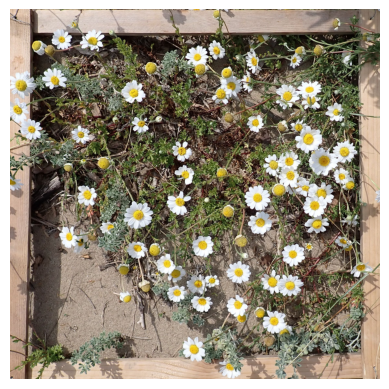

In [3]:
img = Image.open(
    f"{TEST_DATA_PATH}PlantCLEF2025_test_images/PlantCLEF2025_test_images/GUARDEN-CBNMed-30-4-16-3-20240428.jpg"
)
plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
img.size

(2274, 2274)

Load model

In [5]:
MODEL_FOLDER_PATH = f"{PROJECT_PATH}models/"

device = torch.device("cuda")
model = timm.create_model(
    "vit_base_patch14_reg4_dinov2.lvd142m",
    pretrained=False,
    num_classes=len(df_species_ids),
    checkpoint_path=f"{MODEL_FOLDER_PATH}model_onlyclassifier_then_all/model_best.pth.tar",
)
model = model.to(device)
model = model.eval()

Print the top 5 scores.

In [6]:
# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

with torch.no_grad():
    if img != None:
        img = transforms(img).unsqueeze(0)
        img = img.to(device)
        output = model(img)  # unsqueeze single image into batch of 1
        top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1), k=5)
        top5_probabilities = top5_probabilities.cpu().detach().numpy()
        top5_class_indices = top5_class_indices.cpu().detach().numpy()

        for proba, cid in zip(top5_probabilities[0], top5_class_indices[0]):
            species_id = df_species_ids.iloc[cid].item()
            species = id_to_species.loc[species_id].item()
            print(species_id, species, proba)

1394664 Anthemis tomentosa L. 0.106993034


KeyError: 1398319

As observed from the predictions, since the model is trained on a mono-label dataset, two predicted species could both be present in the quadrat, or the model might be uncertain between them.